In [102]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from thinkdsp import *
import os
from tqdm.notebook import tqdm
import multiprocessing as mp
import audiomentations as A
from pathlib import Path
import re
import librosa

plt.ioff()

This function creates a spectrogram from an audio way to match the input of original model.

In [103]:
def non_diff_spec(x):
    # Create spectrogram
    wave = Wave(ys=x.numpy().flatten(), framerate=16000)
    wave.make_spectrogram(1024).plot(high=5000)

    # Dump spectrogram to disk
    # Same process as the data preparation for the original model
    plt.axis('off')
    plt.savefig('loh.png', bbox_inches='tight', pad_inches=0)
    plt.clf()
    
    # Load the spectrogram to return it
    with Image.open('loh.png') as img:
        img = np.asarray(img)[None, :,:,:3]
        
    # Convert to tensor and normalize
    return tf.convert_to_tensor(img, dtype=tf.float32) / 255.

First of all, let's see what does the data look like.

The first observation is that not all range of audio has active regions. Also, this region can occur in any place of the audio. I will use that fact later.

The second obseration is that intensities of different frequencies can be different even for the same class. For example, look at two spectrograms below from class 'no'. One of them has some energy on high frequencies, for the other one they are almost not visible. It seems that the model should be resistant to changes in frequency intensities. Therefore, I'd rather not use the strategy of adding/removing frequencies.

The third observation is that formants are visible, and the modely surely uses this information. But changing them could bring two difficulties: first, if I change the formant, I may change the sound itself, so it will be hard for a human to classify the audio correctly. This is undesirable because I want to create an attack which fools only the model and not the human. Second, it would be hard to change the formant because the duration of corresponding vowel sound is bigger than the number of entries which is allowed to change.

In the previous paragraphs I reviewed some possible strategies which are complicated to implement and all have their drawbacks. Therefore, I will try to stick with the simplest but nevertheless highly effective technique which I'll describe next.

no


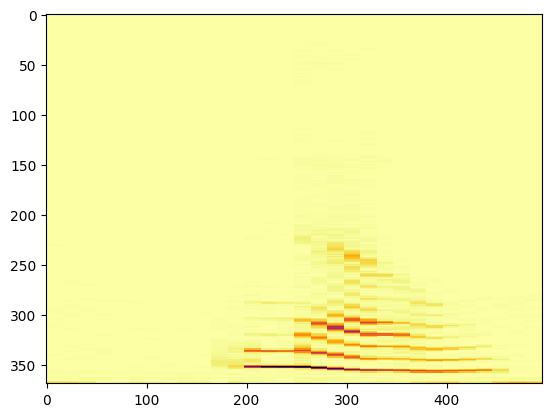

no


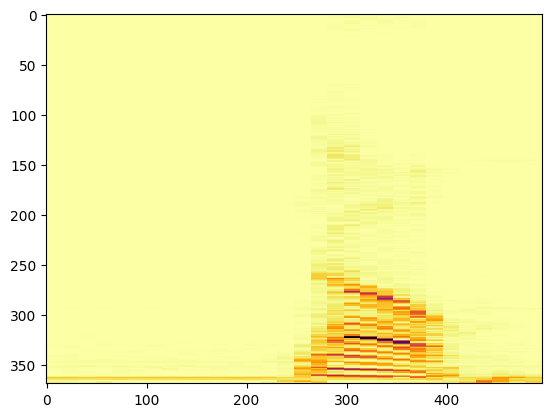

yes


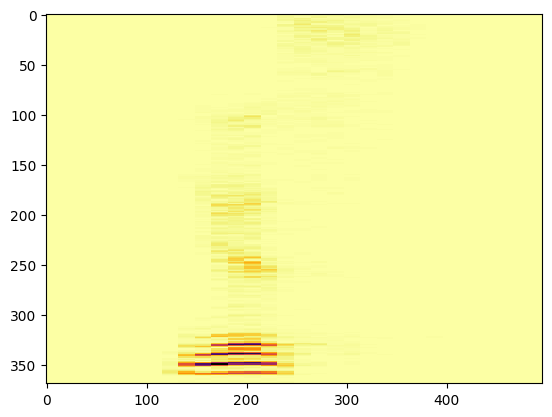

Number of elements which are allowed to change: 2400.0.


In [136]:
wavs = list(map(str, Path('test_audio').rglob('*.wav')))

for i in [0, 100, 700]:
    cls = re.findall(r'/(\w+)/', wavs[i])[0]
    print(cls)
    wave = read_wave(wavs[i])
    spec = non_diff_spec(tf.convert_to_tensor(wave.ys)).numpy()[0]
    plt.imshow(spec)
    plt.show()
    
print(f"Number of elements which are allowed to change: {wave.ys.shape[0] * 0.15}.")

Load the model.

In [104]:
with tf.device('/cpu'):
    model = tf.keras.models.load_model('my_model', compile=False)

A helper function for prediction of the wave class.

In [105]:
def pred(wave):
    wave = tf.convert_to_tensor(wave.ys[None, :, None])
    spec = non_diff_spec(wave)
    with tf.device('/cpu'):
        ans = model(spec)
        return test_ds.class_names[tf.math.argmax(ans[0])]

Intuitively it should be obvious that in order to fool the model with the highest probability, we need to change a segment which actually is important for the model. In our case this is a segment where a person pronouns the word. Therefore, I use the detection of an active region on an audio to accurately choose a segment to change.

My experiment showed that without this strategy the performance of an attack is much lower compared to attack with careful choice of the segment.

In [106]:
def detect_active_region(audio, sr=16000, thresh=5e-3):
    hop = int(1e-2 * sr)
    # Compute the short-term energy of the audio signal
    energy = librosa.feature.rms(y=audio, 
                                 frame_length=int(1e-2 * sr), 
                                 hop_length=hop)[0]

    # Detect voiced segments
    voiced_frames = np.where(energy > thresh)[0]

    # Convert the frame indices to time intervals
    voiced_segments = librosa.frames_to_time(voiced_frames, sr=sr, hop_length=hop)

    if len(voiced_segments) <= 1:
        return 0, 1
    
    return voiced_segments.min(), voiced_segments.max()

The idea of fooling a neural network is to introduce a distortion which doesn't prevent human from classifying the audio correctly, but leads to an incorrect prediction by a neural network.

A good candidate for this task is to add a small noise to an image, use downsampling, change audio quality, etc. This can in general be called an augmentation. During training this technique could help to make the model more robust and to generalize better. However, if it wasn't use during training and the model has overfitted on the training data, such augmented samples can become a challange during test-time. Thus, I will try to use it for this task.

In [107]:
augment = A.Compose([
    A.AddGaussianNoise(min_amplitude=0.001, max_amplitude=0.015, p=1),
    A.PitchShift(min_semitones=-4, max_semitones=4, p=1),
    A.AirAbsorption(p=1),
    A.BandPassFilter(p=1),
    A.TanhDistortion(min_distortion=0.01, max_distortion=0.7, p=1.0)
])

In [108]:
import random

def attack(path):
    # Load the audio
    wave = read_wave(path)
    # Detect the range where there is a word
    fr, to = detect_active_region(wave.ys, sr=wave.framerate)
    # In case this range is smaller than the length of the segment that I will change
    # - artificially expand the bounds.
    if to - fr < 0.15:
        to = min(to + .15, 1)
        fr = max(fr - .15, 0)

    assert fr <= to - 0.15, (fr, to)
    # Choose a random position as the beginning of the segment
    offset = random.uniform(fr, to - 0.15)
    # Calculate segment bounds
    fr_i = int((offset) * wave.ys.shape[0])
    to_i = int((offset + 0.15) * wave.ys.shape[0])

    # Rewrite the segment with an augmented version
    wave.ys[fr_i:to_i] = augment(wave.ys[fr_i:to_i], sample_rate=16000)
    
    return wave

Now, apply the attack to all samples in the dataset.

In [ ]:
def helper(i):
    """
    A helper function for processing of a single wave
    """
    # Extract real class of the wave
    real_cls = re.findall(r'/(\w+)/', i)[0]
    # Prediction of the model for unmodified wave
    orig_wave = read_wave(i)
    orig_pred = pred(orig_wave)
    # If the model already fails on this sample 
    # - we don't need to do anything
    if orig_pred != real_cls:
        adv_wave = orig_wave
        adv_pred = orig_pred
    else:
        # Prediction of the model for modified wave
        adv_wave = attack(i)
        adv_pred = pred(adv_wave)
    
    return real_cls, orig_pred, adv_pred

# with mp.Pool() as pool:
#     out = pool.map(helper, tqdm(wavs))
out = list(map(helper, tqdm(wavs)))
    
real_clss, orig_preds, preds = zip(*out)
real_clss = np.array(real_clss)
orig_preds = np.array(orig_preds)
preds = np.array(preds)

In [125]:
orig_preds = np.array(orig_preds)
preds = np.array(preds)
real_clss = np.array(real_clss)

In [126]:
def acc(y1, y2):
    return np.sum(y1 == y2) / len(y1)

You can see that my strategy decreases the accuracy of the model by 10%

In [127]:
acc(real_clss, orig_preds), acc(real_clss, preds)

(0.6929330831769857, 0.5909943714821764)

Here is an illustration of my attack: you can hear that the distortion is quite small so a human can still recognize a word. However, the model fails giving a completely incorrect result.

In [124]:
random.seed(0)
np.random.seed(0)
for i in [5, 6, 1011]:
    real_cls = re.findall(r'/(\w+)/', wavs[i])[0]
    orig_wave = read_wave(wavs[i])
    display(orig_wave.make_audio())
    orig_pred = pred(orig_wave)
    adv_wave = attack(wavs[i])
    display(adv_wave.make_audio())
    adv_pred = pred(adv_wave)
    print(real_cls, orig_pred, adv_pred)

no no left


no no down


up up left
